<a href="https://colab.research.google.com/github/lorek/MethodsClassDimRed/blob/main/MoCaDR_List_nr_8_GMM_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Methods of classification and dimensionality reduction**


Paweł Lorek  
University of Wrocław

# LIST NR 8: GMM -- PyTorch (short list)



 <font face="Rage" size=2  > Updated: 08.04.2025 <font>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal, chi2
from sklearn.metrics import accuracy_score


<ipython-input-2-55ae7a17bdec>:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X1 = np.random.multivariate_normal(mu1, Sigma1, size=300)


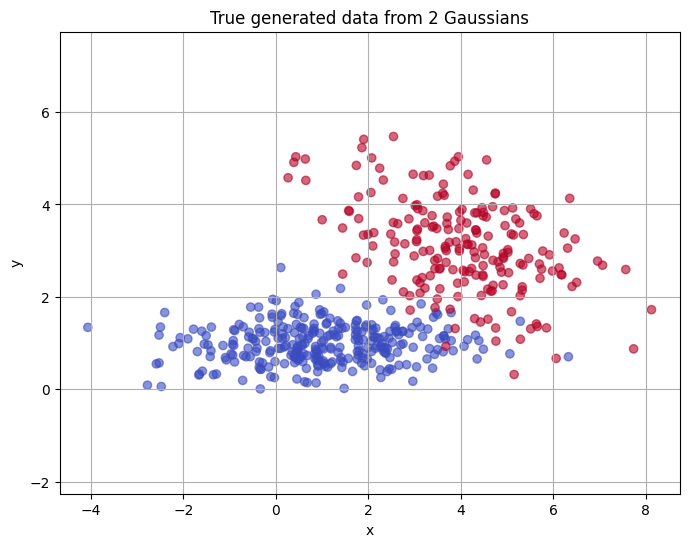

In [ ]:
# --- Step 1: Simulate data from 2  ifferent Gaussians ---
np.random.seed(42)

mu1 = np.array([1, 1])
Sigma1 = np.array([[2.5, 0], [1, 0.2]])
X1 = np.random.multivariate_normal(mu1, Sigma1, size=300)

mu2 = np.array([4, 3])
Sigma2 = np.array([[2.1, -0.8], [-0.8, 1.1]])
X2 = np.random.multivariate_normal(mu2, Sigma2, size=200)

X = np.vstack([X1, X2])
true_labels = np.array([0]*300 + [1]*200)

# --- Step 2: Plot true data with colors ---
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='coolwarm', alpha=0.6)
plt.title("True generated data from 2 Gaussians")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis('equal')
plt.show()

In [ ]:
# --- Step 3: Fit a GMM model from sklearn ---
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X)

# Extract parameters
mu_est = gmm.means_
Sigma_est = gmm.covariances_
pi_est = gmm.weights_

print("Estimated means:\n", mu_est)
print("Estimated covariances:\n", Sigma_est)
print("Estimated mixture weights:\n", pi_est)

Estimated means:
 [[1.01772966 0.98666351]
 [3.96994867 3.08131654]]
Estimated covariances:
 [[[ 2.5863264   0.07068196]
  [ 0.07068196  0.16546051]]

 [[ 2.1061435  -0.57828497]
  [-0.57828497  0.98834831]]]
Estimated mixture weights:
 [0.59469217 0.40530783]


In [ ]:
# --- Predict posterior probabilities ---
probs = np.array([pi_est[k] * multivariate_normal.pdf(X, mean=mu_est[k], cov=Sigma_est[k]) for k in range(2)])
probs /= np.sum(probs, axis=0)
pred_labels = np.argmax(probs, axis=0)



In [ ]:
acc_sklearn=max(accuracy_score(true_labels,pred_labels),accuracy_score(true_labels,1-pred_labels))
print(f"Sklearn GMM accuracy: {acc_sklearn:.4f}")

Sklearn GMM accuracy: 0.9800


In [ ]:

# ---   Ellipse drawing function ---
def plot_filled_ellipses(ax, mu, Sigma, levels=[0.80, 0.85, 0.90], base_alpha=0.15):
    vals, vecs = np.linalg.eigh(Sigma)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    for conf in levels:
        r = np.sqrt(chi2.ppf(conf, df=2))
        width, height = 2 * r * np.sqrt(vals)
        e = Ellipse(xy=mu, width=width, height=height, angle=theta,
              facecolor='gray', edgecolor='none', alpha=base_alpha + (conf - levels[0]) * 1.2)

        ax.add_patch(e)


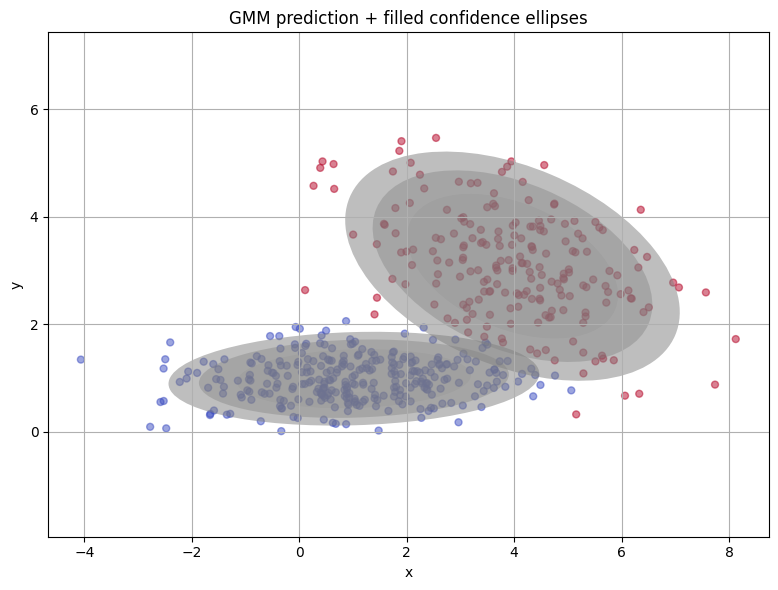

In [ ]:
# --- Plot with predicted colors and filled ellipses ---
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[:, 0], X[:, 1], c=pred_labels, cmap='coolwarm', alpha=0.5, s=25)

for k in range(2):
    plot_filled_ellipses(ax, mu_est[k], Sigma_est[k], levels=[0.60, 0.8, 0.90])

ax.set_title("GMM prediction + filled confidence ellipses")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()

##  Fitting a Gaussian Mixture Model (GMM) with PyTorch – Optimization-Based Approach


While traditional GMM fitting is performed using the **EM algorithm** (as used by `sklearn.mixture.GaussianMixture`), this is **not the only way**. Instead, we can directly **optimize the log-likelihood** function using gradient-based methods like **SGD** or **Adam** — and PyTorch makes this easy.

---

###   Model Setup

We assume a 2-component GMM in 2D. The parameters to estimate are:

- **Mixing proportions**: instead of directly optimizing $\alpha_1$, $\alpha_2$, we optimize two real values $p_1, p_2$ and compute:
  $$
  \alpha_k = \frac{\exp(p_k)}{\exp(p_1) + \exp(p_2)} \quad \text{(softmax)}
  $$

- **Means** of the Gaussians:  
  $$\boldsymbol{\mu}_1 = (\mu_{11}, \mu_{12}), \quad \boldsymbol{\mu}_2 = (\mu_{21}, \mu_{22})$$

- **Covariance matrices**:  
  We use a **Cholesky decomposition** to ensure each covariance matrix is symmetric and positive definite.  
  For each $k = 1, 2$, we store:
  $$
  \mathbf{L}_k = \begin{bmatrix}
  a_k & 0 \\
  b_k & c_k
  \end{bmatrix}, \quad \boldsymbol{\Sigma}_k = \mathbf{L}_k \mathbf{L}_k^\top
  $$
  The parameters $a_k, b_k, c_k$ are real-valued and unconstrained; this ensures $\boldsymbol{\Sigma}_k$   is always valid.



# Q8.1 (**10 pts**)

* In this exercise, we will fit a **Gaussian Mixture Model (GMM)** to 2D data using **PyTorch** and automatic differentiation.

* You are given the full setup and initializations. Your goal is to **complete the missing part of the training loop**, by computing the **log-likelihood** for the mixture model:
$$
\log p(x_i) = \log\left( \alpha_1 \cdot \mathcal{N}(x_i \mid \boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1) + \alpha_2 \cdot \mathcal{N}(x_i \mid \boldsymbol{\mu}_2, \boldsymbol{\Sigma}_2) \right)
$$
* Plot fitted model using previous `plot_filled_ellipses`
* After fitting, make data classification: classify each point to class
$$\textrm{pred}(x_i)=\textrm{argmax}_{i=1,2} p(x_i).$$ Comput accuracy, compare with `sklearn` GMM model


Notes:
* You can use `torch.distributions.Multivariate`

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Set seed and device
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cpu")

In [ ]:
X_torch= torch.tensor(X, dtype=torch.float32)

In [ ]:
p = torch.randn(2, requires_grad=True)

mu1 = torch.randn(2, requires_grad=True)
mu2 = torch.randn(2, requires_grad=True)

a1 = torch.tensor(1.0, requires_grad=True)
b1 = torch.tensor(0.0, requires_grad=True)
c1 = torch.tensor(1.0, requires_grad=True)

a2 = torch.tensor(1.0, requires_grad=True)
b2 = torch.tensor(0.0, requires_grad=True)
c2 = torch.tensor(1.0, requires_grad=True)

In [ ]:
# === Optimization ===
lr = 0.02
n_epochs = 2000
params = [p, mu1, mu2, a1, b1, c1, a2, b2, c2]
optimizer = torch.optim.Adam(params, lr=lr)

loss_list = []

for epoch in range(n_epochs):
    alpha = torch.softmax(p, dim=0)


    ##########################################################
    ################## TO DO #################################
    ## L1 = torch..........a1, b1, c1...
    ## L2 = torch..........a2, b2, c3 ...
    ##
    ## Sigma1 =  ....
    ## Sigma2 = ...
    ##
    ## dist1 = torch.distributions....
    ## dist2 = torch.distributions....
    ##
    ##  log_probs = torch.log(....
    ##
    ##########################################################
    ##########################################################

    loss = -torch.mean(log_probs)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_list.append(loss.item())



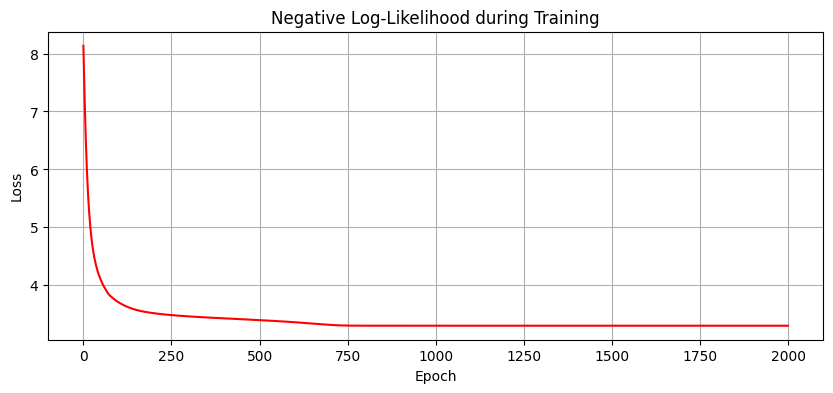

Final loss: 3.3025


In [ ]:
# === Plot loss curve ===
plt.figure(figsize=(10, 4))
plt.plot(loss_list, 'r')
plt.title("Negative Log-Likelihood during Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print(f"Final loss: {loss.item():.4f}")

In [ ]:
# === Final parameter extraction ===
with torch.no_grad():
    alpha = torch.softmax(p, dim=0).numpy()
    mu1_final = mu1.numpy()
    mu2_final = mu2.numpy()

    L1 = np.array([[a1.item(), 0],
                   [b1.item(), c1.item()]])
    L2 = np.array([[a2.item(), 0],
                   [b2.item(), c2.item()]])
    Sigma1_final = L1 @ L1.T
    Sigma2_final = L2 @ L2.T

print("Final estimated parameters:\n")
print(f"alpha = {alpha}")
print(f"mu1 = {mu1_final}")
print(f"mu2 = {mu2_final}")
print(f"Sigma1 =\n{Sigma1_final}")
print(f"Sigma2 =\n{Sigma2_final}")

Final estimated parameters:

alpha = [0.3951328 0.6048672]
mu1 = [3.970745  3.1254396]
mu2 = [1.0668695  0.99307615]
Sigma1 =
[[ 2.11907649 -0.5860683 ]
 [-0.5860683   0.93021586]]
Sigma2 =
[[2.71090962 0.08235038]
 [0.08235038 0.16902162]]


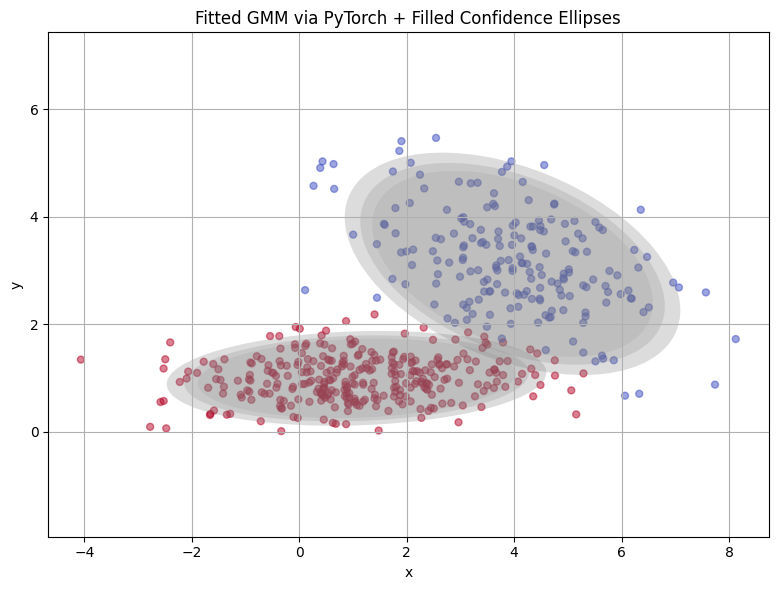

In [ ]:
# Predict cluster using final params
rv1 = multivariate_normal(mean=mu1_final, cov=Sigma1_final)
rv2 = multivariate_normal(mean=mu2_final, cov=Sigma2_final)

p1 = alpha[0] * rv1.pdf(X)
p2 = alpha[1] * rv2.pdf(X)
pred_labels = (p2 > p1).astype(int)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X[:, 0], X[:, 1], c=pred_labels, cmap='coolwarm', s=25, alpha=0.5)

plot_filled_ellipses(ax, mu1_final, Sigma1_final)
plot_filled_ellipses(ax, mu2_final, Sigma2_final)

ax.set_title("Fitted GMM via PyTorch + Filled Confidence Ellipses")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
acc_torch = max(
    accuracy_score(true_labels, pred_labels),
    accuracy_score(true_labels, 1 - pred_labels)
)

print(f"PyTorch GMM accuracy: {acc_torch:.4f}")
print(f"Sklearn GMM accuracy: {acc_sklearn:.4f}")

PyTorch GMM accuracy: 0.9740
Sklearn GMM accuracy: 0.9800


## First(?) generative model with GMM

In [ ]:

def draw_ellipse(position, covariance, ax, alpha):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(xy=position,
                             width=nsig * width,
                             height=nsig * height,
                             angle=angle,
                             alpha=alpha))


In [ ]:
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans


In [ ]:

points, classes_true  = make_moons(200, noise=.05, random_state=0)




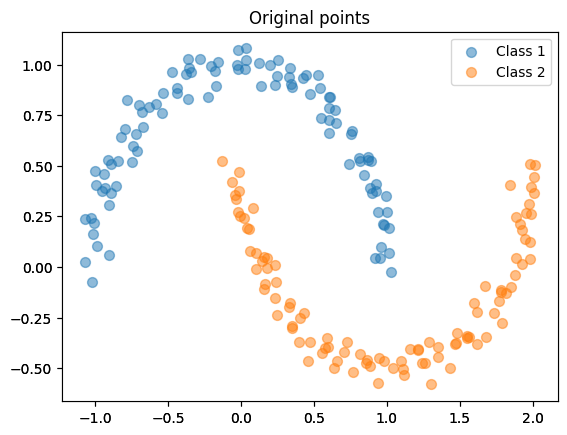

In [ ]:

x=points[:,0]
y=points[:,1]

classes_names=["Class 1", "Class 2"]

plt.scatter(x , y);


fig_oryg=plt.figure(1)
ax_oryg=fig_oryg.add_subplot(111 )




for cl in range(2):
	ax_oryg.scatter(x[classes_true==cl],y[classes_true==cl], label=classes_names[cl], s=50, alpha=0.5);


ax_oryg.set_title("Original points")
ax_oryg.legend()

### GMM(k=2)

Does GMM with `k=2` components "fits" data?

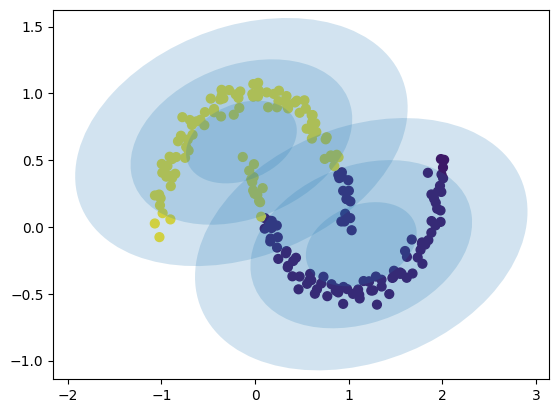

In [ ]:
# GMM
gmm =  GaussianMixture(n_components=2)
gmm.fit(points)
clusters_gmm = gmm.predict(points)

gmm_aic = gmm.fit(points).aic(points)

fig_gmm=plt.figure(3)
ax_gmm=fig_gmm.add_subplot(111 )


ax_gmm.scatter(x,y, c=clusters_gmm, s=40);




#draw ellipses:
w_factor = 0.2 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
	draw_ellipse(pos, covar, ax_gmm , alpha=w * w_factor)

Not good fit...

try `k=2,3,4,..,50` components and find out one with **best** (smallest) AIC:

<ipython-input-73-fb30f36d81dd>:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_gmm2.legend()


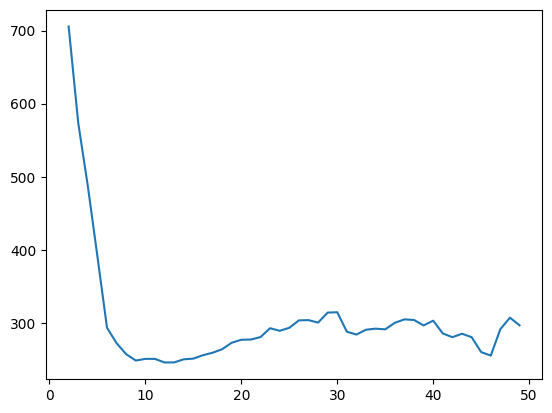

In [ ]:
fig_aic=plt.figure(5)
ax_aic=fig_aic.add_subplot(111 )

n_components = np.arange(2, 50, 1)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(points).aic(points) for model in models]
ax_aic.plot(n_components, aics);
ax_gmm2.set_title("AIC for 'moons' for n_components in range(2,50)")
ax_gmm2.legend()

In [ ]:
best_index = np.argmin(aics)
best_n_components = n_components[best_index]
print("best_n_components = ",best_n_components)

best_n_components =  12


### GMM(k=12)

Text(0.5, 1.0, 'GMM: n_components = 12 AIC = 257.69')

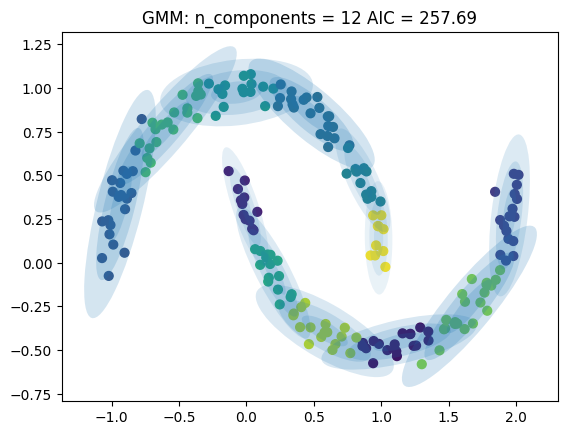

In [ ]:
nr_clusters=12
gmm2 =  GaussianMixture(n_components=nr_clusters)
gmm2.fit(points)
gmm2_aic = gmm2.fit(points).aic(points)

clusters_gmm2 = gmm2.predict(points)

fig_gmm2=plt.figure(4)
ax_gmm2=fig_gmm2.add_subplot(111)



ax_gmm2.scatter(x,y, c=clusters_gmm2, s=40);


w_factor = 0.2 / gmm2.weights_.max()
for pos, covar, w in zip(gmm2.means_, gmm2.covariances_, gmm2.weights_):
	draw_ellipse(pos, covar, ax_gmm2 , alpha=w * w_factor)

ax_gmm2.set_title('GMM: n_components = ' +  str(nr_clusters) + " AIC = " + str(np.round(gmm2_aic,2)))

**Good fit!**

Lets sample from trained model -- check by "eye inspection" that this represents moon dataset quite well

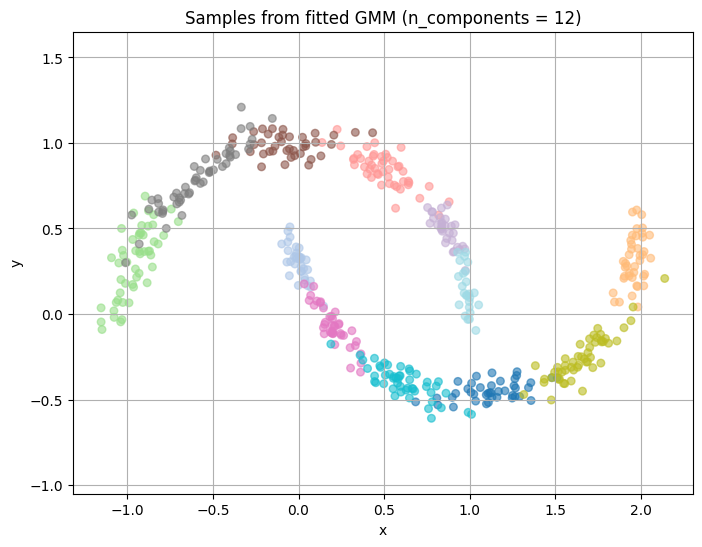

In [ ]:
# Sample 500 points from the fitted GMM model
sampled_points, sampled_labels = gmm2.sample(500)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], c=sampled_labels, cmap='tab20', s=30, alpha=0.6)
plt.title("Samples from fitted GMM (n_components = {})".format(gmm2.n_components))
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis('equal')
plt.show()

## Genearting MNIST images!

Loading 8x8 digits dataset...
Shape of data: (1797, 64), labels: (1797,)


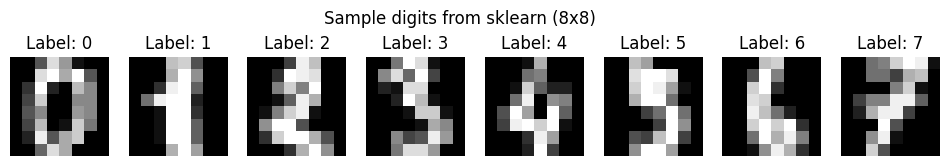

Applying PCA to 3D...


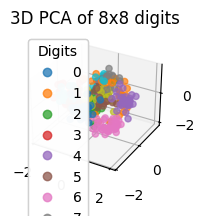

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Step 1: Load digits dataset (8x8 images)
print("Loading 8x8 digits dataset...")
digits = load_digits()
X = digits.data / 16.0  # normalize to [0, 1]
y = digits.target
print(f"Shape of data: {X.shape}, labels: {y.shape}")

# Step 2: Show sample digits
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axes[i].imshow(X[i].reshape(8, 8), cmap='gray')
    axes[i].set_title(f"Label: {y[i]}")
    axes[i].axis('off')
plt.suptitle("Sample digits from sklearn (8x8)")
plt.show()

# Step 3: PCA to 3D and plot
print("Applying PCA to 3D...")
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
idx = np.random.choice(X.shape[0], 300, replace=False)
scatter = ax.scatter(X_pca3[idx, 0], X_pca3[idx, 1], X_pca3[idx, 2], c=y[idx], cmap='tab10', s=20, alpha=0.7)
legend = ax.legend(*scatter.legend_elements(), title="Digits")
ax.add_artist(legend)
ax.set_title("3D PCA of 8x8 digits")
plt.tight_layout()
plt.show()


In [ ]:
len(X)

1797

# Q8.2  (**10 pts**) Fit GMM in 30D PCA Space and Generate New Digits

In this task, you will use the MNIST dataset and a generative model based on **PCA + Gaussian Mixture Model** to **generate** new handwritten digits.

You have already:
- Loaded and visualized the MNIST dataset,
- Reduced the data to 3D using PCA and visualized some samples.


We now move to higher-dimensional latent space to model digit structure more accurately.

---

### Task:

1. **Perform PCA to 30D**:
   - Apply PCA to reduce MNIST images (784D) to 30 dimensions.
   - Store the fitted PCA object for inverse transformation.

2. **Fit a GMM in the 30D PCA space**:
   - Fit the  `GaussianMixture` model with `k=30` components.

3. **Generate new digits**:
   - Sample at least **10 new points** from the fitted GMM in the 30D space.
   - Use the `pca.inverse_transform(...)` method to map them back to the original 784D space.
   - Display the resulting digit images using `imshow(...)`. (two rows, 5 images per row)

4. **Repeat above for "optimal" number of components**:
   - Consider some range of components `n_components = np.arange(..., ..., 1)`
   - Use the **AIC** criterion to select the best number of components, draw also a plot: `n_components` $\times$ `AIC`
   - Repeat previous steps for this best nr of components
   

### Tips

- Use `sklearn.decomposition.PCA` and `sklearn.mixture.GaussianMixture`.
- Normalize MNIST images to the [0, 1] range before applying PCA.
- When showing generated digits, use `plt.subplots(...)` with `cmap='gray'` and turn off axes.
